# Align with Void Tracking
The void tracks from the FFTs seem to have a large degree of jumps. Let's try to align images in a way which minimizes the net motion of all voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks, compute_drift
from skimage.transform import AffineTransform, warp
from pathlib import Path
from tqdm import tqdm
import trackpy as tp
import pandas as pd
import numpy as np
import imageio

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Determine location of keys files

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
defect_file = out_directory / 'defect-details.json'

## Determine the drift from defect movement
We are going to do a very conservative particle tracking and evaluate drift based on the average movement of all defects.

In [4]:
frame_data = pd.read_json(defect_file, lines=True).sort_values('image-path')
print(f'Loaded data from {len(frame_data)} frames')

Loaded data from 969 frames


In [5]:
images = sorted((run_directory / 'masks/').glob('*tif'))
print(f'Found {len(images)} images')

Found 969 images


Do a check where we only allow small movements of voids and do not remember them for more than 3 frames

In [6]:
%%time
particles = pd.concat(list(convert_to_per_particle(frame_data, position_col='positions')))
initial_tracks = tp.link_df(particles, search_range=16, memory=4)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles out of {frame_data["void_count"].sum()} total')

Frame 968: 18 trajectories present.
Found a total of 2653 unique particles out of 14536 total
CPU times: user 1.33 s, sys: 155 ms, total: 1.48 s
Wall time: 1.37 s


Compute the median drift between each frame

In [7]:
total_drift = compute_drift(initial_tracks)

Plot how the drift goes over time.

In [8]:
initial_tracks['radius'].describe()

count    14536.000000
mean        10.338094
std          5.897616
min          3.989423
25%          5.014627
50%          7.399277
75%         15.897737
max         22.046750
Name: radius, dtype: float64

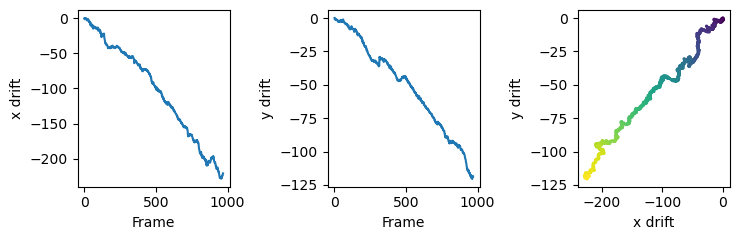

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-tracks.png', dpi=320)

## See if there is a correlated motion between many voids
That's the halmark of "image drift" rather than natural movement between voids

In [10]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
383,314,968,655,7,"[[216.0901162791, 288.8110465116], [215.813411...","[6, 9, 4, 6, 3, 7, 6, 3, 3, 8, 7, 5, 5, 2, 4, ...","[0.0, 0.5072278650544422, 0.5155272083426694, ...",197.078794,0.300884,"[0.0, 0.5072278650544422, 1.0975330226829452, ...",914.876832,1.396759,"[10.4641579139, 10.4489373125, 10.1867081482, ...",14.328638,4.068429,-0.002760
377,314,968,655,2,"[[366.5066864785, 596.4947994056], [366.967832...","[12, 12, 7, 10, 6, 15, 10, 5, 5, 13, 9, 9, 9, ...","[0.0, 0.6522202091471705, 0.12744424588375775,...",197.805773,0.301994,"[0.0, 0.6522202091471705, 1.1810378348470998, ...",837.925207,1.279275,"[14.6363435803, 15.0861382939, 15.6352803809, ...",16.935088,6.746726,-0.000926


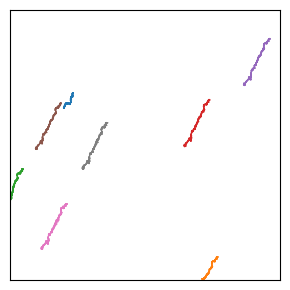

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(8)
for pos in longest_tracks['positions']:
    ax.scatter(pos[:, 0], pos[:, 1], s=1, edgecolor='none')

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.savefig(out_directory / 'figures/collective-movement.png', dpi=320)

There is a fair amount of drift!

In [12]:
corrected_tracks = initial_tracks.copy()
corrected_tracks['x'] -= total_drift[initial_tracks['frame'], 0]
corrected_tracks['y'] -= total_drift[initial_tracks['frame'], 1]
void_tracks = compile_void_tracks(corrected_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
383,314,968,655,7,"[[245.62705401353008, 342.5585961691428], [244...","[6, 9, 4, 6, 3, 7, 6, 3, 3, 8, 7, 5, 5, 2, 4, ...","[0.0, 1.8171632233201016, 0.9120848649671146, ...",14.222963,0.021714,"[0.0, 1.8171632233201016, 2.732387445885227, 2...",721.788108,1.101967,"[10.4641579139, 10.4489373125, 10.1867081482, ...",14.328638,4.068429,-0.002760
377,314,968,655,2,"[[396.04362421293007, 650.2423490631428], [396...","[12, 12, 7, 10, 6, 15, 10, 5, 5, 13, 9, 9, 9, ...","[0.0, 0.7581924823700438, 0.9145738349724203, ...",9.875775,0.015078,"[0.0, 0.7581924823700438, 1.0857259668038264, ...",631.755462,0.964512,"[14.6363435803, 15.0861382939, 15.6352803809, ...",16.935088,6.746726,-0.000926


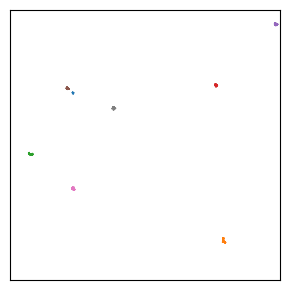

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(8)
for pos in longest_tracks['positions']:
    ax.scatter(pos[:, 0], pos[:, 1], s=1, edgecolor='none')

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.savefig(out_directory / 'figures/subtracted-off-movement.png', dpi=320)

We can remove it

In [22]:
frame_1, frame_2 = 100, 150

In [23]:
image_1 = imageio.read(images[frame_1]).get_data(0)
image_2 = imageio.read(images[frame_2]).get_data(0)

In [24]:
drift = total_drift[frame_2, :] - total_drift[frame_1, :]
drift

array([ -2.22121971, -20.14911217])

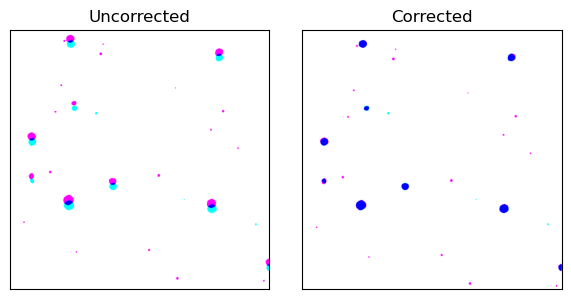

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= image_1
image[:, :, 1] -= image_2
axs[0].imshow(image)
axs[0].set_title('Uncorrected')

# Plot the re-registered images
affine = AffineTransform(translation=drift)
image_2_shift = np.array(warp(image_2, affine) * 255, dtype=np.uint8)
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= image_1
image[:, :, 1] -= image_2_shift
axs[1].imshow(image)
axs[1].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation-tracks.png', dpi=320)

## Save for later use
Save the drifts and the defect coordinates

In [26]:
out_path = out_directory / 'drifts-tracks.csv'
pd.DataFrame(total_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

Update the coordinates too

In [27]:
frame_data['positions_corrected-track'] = [(x - y) if len(x) > 0 else x for x, y in zip(frame_data['positions'], total_drift)]
frame_data['drift'] = total_drift.tolist()

In [28]:
frame_data.to_json(out_directory / 'defect-details.json', orient='records', lines=True)